In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

2023-05-20 09:20:24.081833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/lezhocheck/opt/anaconda3/envs/py3tf2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### EMNIST dataset is used for training the model that recognizes handwritten VIN-code characters.
##### It is one of the best options to choose for training, because it is enough big and very suitable for this kind of problem

In [2]:
emnist, info = tfds.load('emnist', with_info=True, as_supervised=True)
emnist_train, emnist_test = emnist['train'], emnist['test']

print(info)

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/byclass/3.0.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST ByClass
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_path='/Users/lezhocheck/tensorflow_datasets/emnist/byclass/3.0.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=349.16 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=62),
    }),
    s

2023-05-20 09:20:27.043546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
NUM_VALIDATION = int(0.1 * len(emnist_train))
BUFFER_SIZE = 10000
BATCH_SIZE = 1000
OUTPUT_SIZE = info.features['label'].num_classes
NUM_EPOCHS = 12

print(f'Number of classes: {OUTPUT_SIZE}')


Number of classes: 62


The datset contains handwritten digits, uppercase letters and lowercase letters. VIN contains only uppercase letters and digits, but some letters can be written as lowercase, so it is better to classify them as lowercase letters and then convert them to uppercase if necessary.

In [4]:
# Let's scale grayscale image to bound it pixel values between 0..1
def scale(image, label):
    image = tf.cast(image, tf.float32)
    return image / 255., label

scaled_train_validation_data = emnist_train.map(scale)
scaled_test_data = emnist_test.map(scale)

In [5]:
# Shuffling data and creating a validation dataset to prevent overfitting during training
shuffled_scaled_train_validation_data = scaled_train_validation_data.shuffle(BUFFER_SIZE)
shuffled_test_data = scaled_test_data.shuffle(BUFFER_SIZE)

validation_data = shuffled_scaled_train_validation_data.take(NUM_VALIDATION)
train_data = shuffled_scaled_train_validation_data.skip(NUM_VALIDATION)

In [6]:
# Batching samples
batched_train_data = train_data.batch(BATCH_SIZE)
batched_validation_data = validation_data.batch(NUM_VALIDATION)
batched_test_data = shuffled_test_data.batch(len(shuffled_test_data))

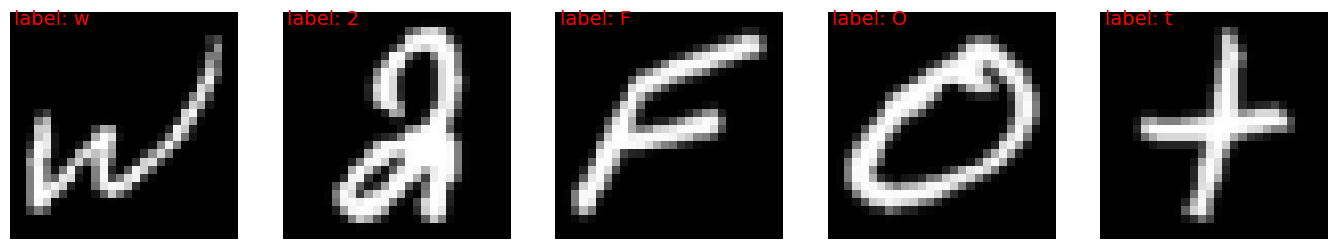

In [42]:
# Convert targets to actual character values
def to_chr(label):
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label + 55)
    return chr(label + 61)

# Let's display some of the dataset entries
def show_one(img, label, ax):
    img = np.fliplr(img)
    img = np.rot90(img, k=1)
    ax.imshow(img, cmap='gray')
    ax.text(0.05, 1, f'label: {to_chr(label)}', fontsize=14, color='red')
    ax.axis('off')


display_count = 5
fig, axs = plt.subplots(1, display_count, figsize=(17, 11))
for ind, value in enumerate(train_data.take(display_count)):
    img, label = value[0].numpy(), value[1].numpy()
    show_one(img, label, axs[ind])
plt.show()

In [8]:
validation_inputs, validation_targets = next(iter(batched_validation_data))

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='softmax')
])

In [10]:
# Compile the model with adam optimizer and 
# sparse_categorical_crossentropy loss function 
# (we have categorical targets that are not one-hot encoded)
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [11]:
# Adding early stopping to prevent possible overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

model.fit(batched_train_data, epochs=NUM_EPOCHS, verbose=2, 
          batch_size=BATCH_SIZE,
          validation_data=(validation_inputs, validation_targets),
          callbacks=[early_stopping])

Epoch 1/12
629/629 - 22s - loss: 0.8467 - accuracy: 0.7515 - val_loss: 0.5798 - val_accuracy: 0.8091 - 22s/epoch - 36ms/step
Epoch 2/12
629/629 - 22s - loss: 0.5177 - accuracy: 0.8255 - val_loss: 0.5007 - val_accuracy: 0.8304 - 22s/epoch - 35ms/step
Epoch 3/12
629/629 - 22s - loss: 0.4667 - accuracy: 0.8381 - val_loss: 0.4655 - val_accuracy: 0.8409 - 22s/epoch - 35ms/step
Epoch 4/12
629/629 - 22s - loss: 0.4393 - accuracy: 0.8448 - val_loss: 0.4545 - val_accuracy: 0.8427 - 22s/epoch - 35ms/step
Epoch 5/12
629/629 - 22s - loss: 0.4201 - accuracy: 0.8498 - val_loss: 0.4446 - val_accuracy: 0.8444 - 22s/epoch - 35ms/step
Epoch 6/12
629/629 - 22s - loss: 0.4058 - accuracy: 0.8534 - val_loss: 0.4396 - val_accuracy: 0.8466 - 22s/epoch - 35ms/step
Epoch 7/12
629/629 - 22s - loss: 0.3942 - accuracy: 0.8563 - val_loss: 0.4309 - val_accuracy: 0.8499 - 22s/epoch - 35ms/step
Epoch 8/12
629/629 - 22s - loss: 0.3837 - accuracy: 0.8595 - val_loss: 0.4268 - val_accuracy: 0.8504 - 22s/epoch - 35ms/step


Training finished with the accuracy 0.86 and validation accuracy 0.85. Let's check model performance on the test dataset.

In [12]:
loss, accuracy = model.evaluate(batched_test_data)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

1/1 [==============================] - 4s 4s/step - loss: 0.4284 - accuracy: 0.8501
Test loss: 0.4284268021583557
Test accuracy: 0.8500898480415344


* Test accuracy is around 0.85, which is probably good result. 
* However, further improvements can be made by hyperparameter tuning or using more sophisticated models (i.e., CNNs).

### Test data generation

In [51]:
def prepare_gen(img):
    result = np.fliplr(img)
    result = np.rot90(result, k=1)
    return tf.cast(result * 255, tf.uint8)

sample = scaled_test_data.shuffle(BUFFER_SIZE)
# jpeg entries
for value in sample.take(5):
    img, label = value[0].numpy(), value[1].numpy()
    img = prepare_gen(img)
    encoded = tf.image.encode_jpeg(img, quality=100)
    tf.io.write_file(f'./test_data/character_{to_chr(label)}.jpg', encoded)

# png entries
for value in sample.take(5):
    img, label = value[0].numpy(), value[1].numpy()
    img = prepare_gen(img)
    encoded = tf.image.encode_png(img)
    tf.io.write_file(f'./test_data/character_{to_chr(label)}.png', encoded)

# scaled entries
for value in sample.take(5):
    img, label = value[0].numpy(), value[1].numpy()
    img = prepare_gen(img)
    new_size = tf.cast(np.random.uniform(0.5, 3) * 28, tf.int32)
    img = tf.image.resize(img, [new_size, new_size])
    img = tf.cast(img, tf.uint8)
    encoded = tf.image.encode_png(img)
    tf.io.write_file(f'./test_data/character_{to_chr(label)}.jpeg', encoded)